# [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

## Highlights

The paper proposed a new architecture that clearly over passed others. It introduced:
- Local Response Normalization
- Overlapping Pooling
- ReLU
- Dropout

### Architecture

![](../assets/alexnet-1.png)

The network maximizes the multinomial logistic regression objective, which is equivalent to maximizing the average across training cases of the log-probability of the correct label under the prediction distribution.

> MaxPool layers are parameterized to overlap ($stride < kernel$)

> The neural network has 60 millions of parameters.

In order to reduce overfitting, two types of **data augmentation** has been employed:
- *image translations and horizontal reflections*
  - Extraction of random $224 \times 224$ patches (along with their horizontal reflections) from $256 \times 256$ resized and cropped images from the training set.
  - At test time, the network makes a prediction by extracting 4 $224 \times 224$ images (four corner patches and the center path), as well as their horizontal reflections (hence ten patches in all), and averagining predictions made by the network's softmax layer on the ten patches.
- *RGB intensities alteration*
  - Perform PCA on the set of RGB pixel vlues throughout the ImageNEt training set
  - Add multiples of the found principales components to the image, with magnitudes proportional to the corresponding eigenvalues times a random variable drawn from a Gaussian with mean zero and standard deviation 0.1:
  $$ I_{xy}' = \left[I_{xy}^R,I_{xy}^G,I_{xy}^B\right]^T + \left[p_1,p_2,p_3\right]\left[\alpha_1\lambda_1,\alpha_2\lambda_2,\alpha_3\lambda_3\right]^T $$
  where:
    - $p_i$ are the eigenvector of the 3x3 covariance matrix of RGB pixel values
    - $\lambda_i$ are the eigenvalues of the 3x3 covariance matric of RGB pixel values
    - $\alpha_i \sim \mathcal{N}(0,0.1)$ the random variable, drawn only once for the entire pixels of an image, each time it appears in the training procedure
  > This scheme approximately captures an important property of natural images, namely, that object identity is invariant to changes in the intensity and color of the illumination.

The architecture contains also Dropout layers, and its usage costs about a factor of two during training. Dropout layers are used after each FCN except the final one (hence two).

The neural network has been trained using SGD with batch size of 128, with a momentum of 0.9 and a decay of 0.0005, important for the model to learn. It is either a regulator and a training error reducer. The update rule for weight $w$ was:

> $$ \begin{array}{ll}
    v_{i+1} := 0.9 v_i - 0.0005 \epsilon w_i - \epsilon \left< \frac{\partial L}{\partial w}\vert_{w_i}\right>_{D_i} \\
    w_{i+1} := w_i + v_{i+1}
\end{array} $$
> where:
> - $i$ is the iteration index
> - $v$ is the momentum variable
> - $\epsilon$ the learning rate
> - $\left< \cdot \right>_{D_i}$ is the average over the $i$-th batch $D_i$.

> Each initial weights of each layers were drawn from $\mathcal{N}(0,0.01)$.
> Biases of 2, 4 and 5 conv layers and all Ffully onnected layers were initialized with the constant 1, as it accelerates the early stages of learning by providing the ReLUs with positive inputs. Other biases were initialized to 0.

> The learning rate $\epsilon$ was divided by 10 when the validation error rate stopped improving with the current learning rate. It was initialized at 0.01 and reduced three times prior termination, leading to about 90 cycles over the entier batch of 1.2 millions images. (5-6 days on two NVIDIA GTX 580 3GB GPUs).

> A valid way to probe the network is to compare images whose generated logits are close in the sense of $l_2$ distance.

## Code

Training code is available here: [http://code.google.com/p/cuda-convnet/](http://code.google.com/p/cuda-convnet/).

In [47]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Resize((224, 224))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


Sneaker  Dress  T-shirt/top  Ankle Boot


/Users/geoffreygdelhomme/miniconda3/envs/cv-ml/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


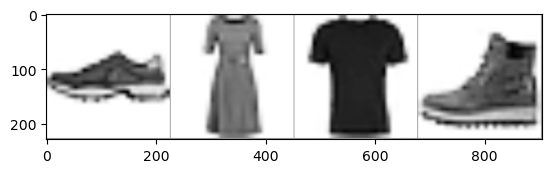

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [49]:
# loss function
loss_fn = torch.nn.CrossEntropyLoss()

In [50]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)
model.classifier[6] = torch.nn.Linear(4096, 10)
model

Using cache found in /Users/geoffreygdelhomme/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/geoffreygdelhomme/miniconda3/envs/cv-ml/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/geoffreygdelhomme/miniconda3/envs/cv-ml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [51]:
from torchinfo import summary

summary(model, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "mult_adds", "params_percent"], col_width=20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Mult-Adds            Param %
AlexNet                                  [1, 3, 224, 224]     [1, 10]              --                   --                        --
├─Sequential: 1-1                        [1, 3, 224, 224]     [1, 256, 6, 6]       --                   --                        --
│    └─Conv2d: 2-1                       [1, 3, 224, 224]     [1, 64, 55, 55]      23,296               70,470,400             0.04%
│    └─ReLU: 2-2                         [1, 64, 55, 55]      [1, 64, 55, 55]      --                   --                        --
│    └─MaxPool2d: 2-3                    [1, 64, 55, 55]      [1, 64, 27, 27]      --                   --                        --
│    └─Conv2d: 2-4                       [1, 64, 27, 27]      [1, 192, 27, 27]     307,392              224,088,768            0.54%
│    └─ReLU: 2-5                         [1, 192, 27, 27]     [1, 192

In [52]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [53]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [54]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/alexnet/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 1.9749946200847626
  batch 2000 loss: 0.9101915928088129
  batch 3000 loss: 0.6860851654907456
  batch 4000 loss: 0.62771512730408
  batch 5000 loss: 0.5310445743007586
  batch 6000 loss: 0.4989514451114519
  batch 7000 loss: 0.4966272966154793
  batch 8000 loss: 0.46376154890244653
  batch 9000 loss: 0.43775053166960426
  batch 10000 loss: 0.41063432667739835
  batch 11000 loss: 0.3956668474758917
  batch 12000 loss: 0.37990296770233545
  batch 13000 loss: 0.38807455757101705
  batch 14000 loss: 0.3733284586046575
  batch 15000 loss: 0.36009422704434835
LOSS train 0.36009422704434835 valid 0.37593790888786316
EPOCH 2:
  batch 1000 loss: 0.3436839255856612
  batch 2000 loss: 0.3486623901922867
  batch 3000 loss: 0.36341240701327476
  batch 4000 loss: 0.34722300229620484
  batch 5000 loss: 0.3379923275905421
  batch 6000 loss: 0.32868759243891643
  batch 7000 loss: 0.31317258076272175
  batch 8000 loss: 0.3360894230326437
  batch 9000 loss: 0.3083702724085756

KeyboardInterrupt: 